# Testing diffusion

In [1]:
using Plots, LinearAlgebra, BenchmarkTools

Defining grid and parameters

In [316]:
const xmax, ymax = 1.0, 2.0
const nx, ny = 8, 16
const nt = 1
const nu = .2

const dx, dy = 2*xmax/(nx-1), 2*ymax/(ny-1)
const sigma = 0.25
const dt = sigma*dx*dy/nu

const x, y = (-xmax : dx : xmax), (-ymax : dy : ymax);

Initialise solution arrays

In [317]:
const u = zeros(ny, nx)
const un = zeros(ny, nx);

Initial conditions

In [318]:
for j = 1 : ny
    for i = 1 : nx
        if abs(x[i]) < 0.4
            if abs(y[j]) < 0.4
                u[j,i] = 1
            end
        end
        #u[j,i] = exp(-32.0*((x[i]-1.3)^2 + (y[j]-1.0)^2)) +
        #         exp(-32.0*((x[i]- 0.7)^2 + (y[j]-1.0)^2));
    end
end

Plot initial conditions

1.0


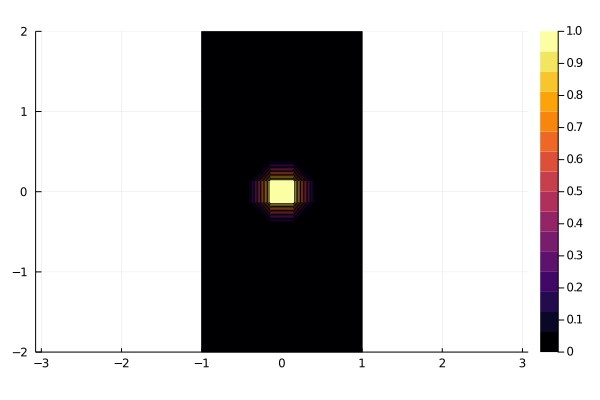

In [319]:
println(maximum(u))
contourf(x, y, u, aspect_ratio=:equal)

## Full 2D, implicit

In [320]:
function diffuse!(u,un,nt,nx,ny,dx,dy,dt,nu)
    for n in 1:nt 
        copy!(un,u)
        for j in 2:ny-1, i in 2:nx-1
            u[j,i] = un[j,i] + 
                nu*dt/(dx*dx)*(un[j  ,i+1]-2*un[j,i]+un[j  ,i-1]) + 
                nu*dt/(dy*dy)*(un[j+1,i  ]-2*un[j,i]+un[j-1,i  ])
        end
        
        u[1,:]   .= 0.0
        u[end,:] .= 0.0
        u[:,1]   .= 0.0
        u[:,end] .= 0.0
        
    end
end

diffuse! (generic function with 2 methods)

0.49880952380952376


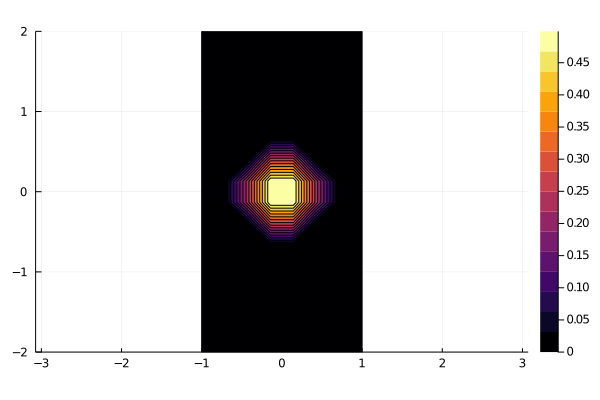

In [321]:
const u_imp = copy(u)
const un_imp = copy(un)
diffuse!(u_imp,un_imp,nt,nx,ny,dx,dy,dt,nu)
println(maximum(u_imp))
contourf(x, y, u_imp, aspect_ratio=:equal)

## Full 2D, Crank-Nickolson

In [322]:
using SparseArrays

CN matrices

In [323]:
function define_mat_CN(nx,ny,dx,dy,dt,nu)
  Nx = (nx-2)
  Nx2 = (nx-2)^2
  Ny = (ny-2)
  Ny2 = (ny-2)^2
  Nxy = Nx*Ny
  betax = 0.5 * nu * dt / (dx*dx)
  betay = 0.5 * nu * dt / (dy*dy)

  # New a1
  a1 = spzeros(Nxy,Nxy)
  ij_ind = LinearIndices((1:Ny, 1:Nx))
  for ij in ij_ind
    a1[ij,ij] = 1 + 2*betax + 2*betay
  end
  for ij in 1:Nx*(Ny-1)
    a1[view(ij_ind,2:Ny,:)[ij],view(ij_ind,1:Ny-1,:)[ij]] = -betay # Up
    a1[view(ij_ind,1:Ny-1,:)[ij],view(ij_ind,2:Ny,:)[ij]] = -betay # Down
  end
  for ij in 1:(Nx-1)*Ny
    a1[view(ij_ind,:,2:Nx)[ij],view(ij_ind,:,1:Nx-1)[ij]] = -betax # Right
    a1[view(ij_ind,:,1:Nx-1)[ij],view(ij_ind,:,2:Nx)[ij]] = -betax # Left
  end

  # New a2
  a2 = spzeros(Nxy,Nxy)
  ij_ind = LinearIndices((1:Ny, 1:Nx))
  for ij in ij_ind
    a2[ij,ij] = 1 - 2*betax - 2*betay
  end
  for ij in 1:Nx*(Ny-1)
    a2[view(ij_ind,2:Ny,:)[ij],view(ij_ind,1:Ny-1,:)[ij]] = betay # Up
    a2[view(ij_ind,1:Ny-1,:)[ij],view(ij_ind,2:Ny,:)[ij]] = betay # Down
  end
  for ij in 1:(Nx-1)*Ny
    a2[view(ij_ind,:,2:Nx)[ij],view(ij_ind,:,1:Nx-1)[ij]] = betax # Right
    a2[view(ij_ind,:,1:Nx-1)[ij],view(ij_ind,:,2:Nx)[ij]] = betax # Left
  end

  a1_lu = factorize(a1)
  return a1_lu, a2
end

define_mat_CN (generic function with 1 method)

CN solvers

In [324]:
function run_for_t_CN!(u,nt)
  rhs = zeros(ny,nx)
  a1, a2 = define_mat_CN(nx,ny,dx,dy,dt,nu)
  un = copy(u)
  #println(maximum(u))
  # loop over time step
  for n = 1 : nt
    run_step_CN!(un, u, rhs, a1, a2)
    #println(maximum(u))
  end
  return nothing
end
function run_step_CN!(un, u, rhs, a1, a2)
  copy!(un,u)
  
  # Views
  unV = @view un[2:end-1,2:end-1]
  unVC = @view unV[:]
  uV = @view u[2:end-1,2:end-1]
  uVC = @view uV[:]
  rhsV = @view rhs[2:end-1,2:end-1]
  rhsVC = @view rhsV[:]
  
  mul!(rhsVC, a2, unVC)
  uVC .= a1\rhsV[:]

  return nothing
end

run_step_CN! (generic function with 1 method)

0.6298313864056275


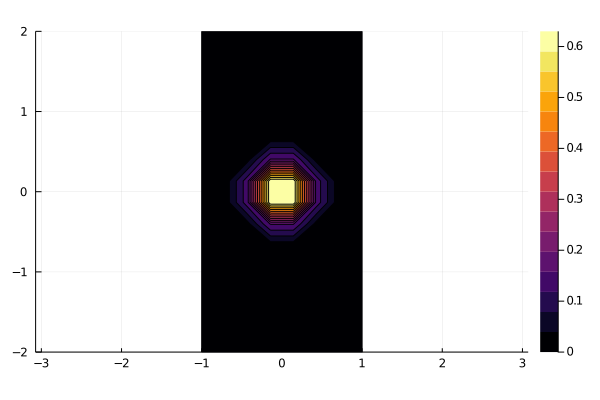

In [325]:
const u_CN = copy(u)
run_for_t_CN!(u_CN,nt)
println(maximum(u_CN))
contourf(x, y, u_CN, aspect_ratio=:equal)

## ADI method

Define matrices

In [326]:
function define_mat_ADI(nx,ny)
  betax = 0.5 * nu * dt / (dx*dx)
  betay = 0.5 * nu * dt / (dy*dy)
  d1x = ones(nx-2) .+ 2 * betax
  e1x = -betax * ones(nx-3)
  d1y = ones(ny-2) .+ 2 * betax
  e1y = -betax * ones(ny-3)
  # matrix ( I - 0.5 nu dt delta_x^2 )
  a1x = SymTridiagonal(d1x,e1x)
  a1y = SymTridiagonal(d1y,e1y)

  d2x = ones(nx-2) .- 2 * betay
  e2x = -betay * ones(nx-3)
  d2y = ones(ny-2) .- 2 * betay
  e2y = -betay * ones(ny-3)
  # matrix ( I + 0.5 nu dt delta_x^2) 
  a2x = SymTridiagonal(d2x,-e2x)
  a2y = SymTridiagonal(d2y,-e2y)
  
  #LDLt factorize
  a1x_ldlt = factorize(a1x)
  a1y_ldlt = factorize(a1y)
  return a1x_ldlt, a1y_ldlt, a2x, a2y
end

define_mat_ADI (generic function with 1 method)

CN solvers

In [ ]:
function run_for_t_ADI(u,nt)
  rhs = zeros(ny,nx)
  uhalf = zeros(ny,nx)
  a1x, a1y, a2x, a2y = define_mat_ADI(nx,ny)
  un = copy(u)

  # loop over time step
  for n = 1 : nt
    run_step_ADI!(un, u, rhs, uhalf, a1x, a1y, a2x, a2y)
  end
  #println(maximum(u))
  return nothing
end
function run_step_ADI!(un, u, rhs, uhalf, a1x, a1y, a2x, a2y)
  copy!(un,u)
  
  # Views
  un_i(i) = @view un[2:end-1,i]
  u_i(i) = @view u[2:end-1,i]
  rhs_j(j) = @view rhs[j,2:end-1]
  rhs_i(i) = @view rhs[2:end-1,i]
  uhalf_j(j) = @view uhalf[j,2:end-1]
  
  # Step one
  for i = 2:size(u)[1]-1
    mul!(rhs_i(i), a2y, un_i(i))
  end
  for j = 2:size(u)[2]-1
    ldiv!(uhalf_j(j), a1x, rhs_j(j))
  end
  
  # Step two
  for j = 2:size(u)[2]-1
    mul!(rhs_j(j), a2x, uhalf_j(j))
  end
  for i = 2:size(u)[1]-1
    ldiv!(u_i(i), a1y, rhs_i(i))
  end
  return nothing
end

In [334]:
a1x, a1y, a2x, a2y = define_mat_ADI(nx,ny)
a1y

LDLt{Float64,SymTridiagonal{Float64,Array{Float64,1}}}
L factor:
14×14 UnitLowerTriangular{Float64,SymTridiagonal{Float64,Array{Float64,1}}}:
  1.0          ⋅           ⋅         …    ⋅           ⋅          ⋅ 
 -0.0945946   1.0          ⋅              ⋅           ⋅          ⋅ 
  0.0        -0.0954487   1.0             ⋅           ⋅          ⋅ 
  0.0         0.0        -0.0954565       ⋅           ⋅          ⋅ 
  0.0         0.0         0.0             ⋅           ⋅          ⋅ 
  0.0         0.0         0.0        …    ⋅           ⋅          ⋅ 
  0.0         0.0         0.0             ⋅           ⋅          ⋅ 
  0.0         0.0         0.0             ⋅           ⋅          ⋅ 
  0.0         0.0         0.0             ⋅           ⋅          ⋅ 
  0.0         0.0         0.0             ⋅           ⋅          ⋅ 
  0.0         0.0         0.0        …    ⋅           ⋅          ⋅ 
  0.0         0.0         0.0            1.0          ⋅          ⋅ 
  0.0         0.0         0.0           -0

In [329]:
u[2:end-1,3]

14-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [332]:
u[12,2:end-1]

6-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0